In [27]:
# Install necessary packages
!pip install xgboost lightgbm catboost --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")


In [28]:
# Load dataset (replace path with your actual .txt file path)
file_path = '/content/power_consumtion_data.txt'

# Read semicolon-separated .txt file
df = pd.read_csv(file_path, sep=';', parse_dates=[['Date', 'Time']], infer_datetime_format=True)

# Rename combined column for easier access
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

# Sort by datetime
df = df.sort_values('Datetime').reset_index(drop=True)

# Display data structure
print("Columns:", df.columns.tolist())
df.head()


Columns: ['Datetime', 'Voltage', 'Global_intensity', 'Global_active_power', 'Load_Status']


,Datetime,Voltage,Global_intensity,Global_active_power,Load_Status
0,01/03/2024 00:00:00,210.83,3.13,0.660,0
1,01/03/2024 00:01:00,230.36,2.78,0.640,0
2,01/03/2024 00:02:00,228.54,7.35,1.680,1
3,01/03/2024 00:03:00,220.82,6.44,1.422,0
4,01/03/2024 00:04:00,249.27,2.72,0.678,0


In [31]:
# Check the first few entries and the dtype of the column
print("First few entries in 'Datetime':")
print(df['Datetime'].head())

print("\nData type of 'Datetime':", df['Datetime'].dtype)


First few entries in 'Datetime':
0    01/03/2024 00:00:00
1    01/03/2024 00:01:00
2    01/03/2024 00:02:00
3    01/03/2024 00:03:00
4    01/03/2024 00:04:00
Name: Datetime, dtype: object

Data type of 'Datetime': object


In [32]:
# If not already converted properly, do it again and clean whitespace
df['Datetime'] = df['Datetime'].astype(str).str.strip()  # remove leading/trailing spaces
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Drop rows where Datetime couldn't be parsed
df = df.dropna(subset=['Datetime'])

# Now try extracting time-based features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['weekday'] = df['Datetime'].dt.weekday

print("Datetime conversion and feature extraction successful!")


Datetime conversion and feature extraction successful!



Columns after preprocessing: ['Datetime', 'Voltage', 'Global_intensity', 'Global_active_power', 'Load_Status', 'hour', 'day', 'weekday']


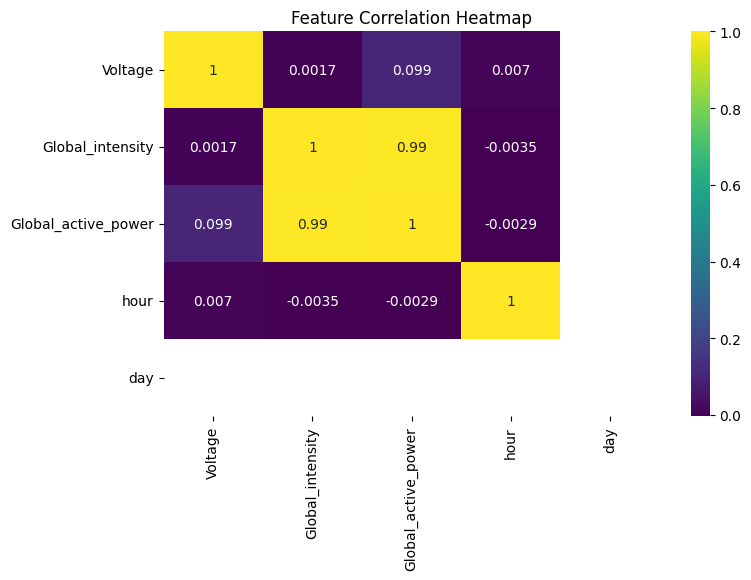


Columns after preprocessing: ['Datetime', 'Voltage', 'Global_intensity', 'Global_active_power', 'Load_Status', 'hour', 'day', 'weekday']


In [33]:
if df['Load_Status'].dtype == 'object':
    df['Load_Status'] = df['Load_Status'].map({'ON': 1, 'OFF': 0})

# Extract time-based features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['weekday'] = df['Datetime'].dt.weekday

# Reorder for better readability
df = df[['Datetime', 'Voltage', 'Global_intensity', 'Global_active_power', 'Load_Status', 'hour', 'day', 'weekday']]

# Display cleaned data structure
print("\nColumns after preprocessing:", df.columns.tolist())
df.head()
# Visualize correlation
plt.figure(figsize=(8, 5))
sns.heatmap(df[['Voltage', 'Global_intensity', 'Global_active_power', 'hour', 'day']].corr(), annot=True, cmap='viridis')
plt.title("Feature Correlation Heatmap")
plt.show()

print("\nColumns after preprocessing:", df.columns.tolist())


In [43]:
# Load the dataset again
df = pd.read_csv('/content/power_consumtion_data.txt', sep=';')

# Combine 'Date' and 'Time' columns into 'Datetime'
# Specify the format explicitly to match your data "DD/MM/YYYY HH:MM:SS"
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Now you can drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Create time-based features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['weekday'] = df['Datetime'].dt.weekday

# ... (rest of your feature engineering code) ...

# Lag Features (previous time steps)
df['lag1'] = df['Global_active_power'].shift(1)
df['lag2'] = df['Global_active_power'].shift(2)

# Rolling window statistics (mean over the last 3 hours)
df['rolling_mean'] = df['Global_active_power'].rolling(window=3).mean()

# Percentage change (between two consecutive time steps)
df['power_change'] = df['Global_active_power'].pct_change()

# Fill missing values generated by shifts or rolling functions
df.fillna(method='bfill', inplace=True)

# Drop the 'Datetime' column as it's no longer needed
df.drop(columns=['Datetime'], inplace=True)

# Final columns
print("Columns after feature engineering:", df.columns)

Columns after feature engineering: Index(['Voltage', 'Global_intensity', 'Global_active_power', 'Load_Status',
       'hour', 'day', 'weekday', 'lag1', 'lag2', 'rolling_mean',
       'power_change'],
      dtype='object')


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features (excluding the target 'Load_Status')
X = df.drop(columns=['Load_Status'])

# Target variable
y = df['Load_Status']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shape of the resulting data
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (34560, 10)
Test features shape: (8640, 10)


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
models = {
    "XGBoost": xgb.XGBRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "CatBoost": cb.CatBoostRegressor(learning_rate=0.1, iterations=500, depth=6, silent=True)
}

# Hyperparameter grids for each model
param_grids = {
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.01, 0.1],
    },
    "LightGBM": {
        'num_leaves': [31, 40],
        'max_depth': [5, 6],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
    },
    "CatBoost": {
        'learning_rate': [0.01, 0.1],
        'iterations': [100, 200],
        'depth': [5, 6, 7],
    }
}

# Hyperparameter tuning using GridSearchCV
best_models = {}
for name, model in models.items():
    print(f"Training {name} model with hyperparameter tuning...")

    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_models[name] = grid_search.best_estimator_

    # Get the best parameters
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Training XGBoost model with hyperparameter tuning...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Training LightGBM model with hyperparameter tuning...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 34560, number of used features: 10
[LightGBM] [Info] Start training from score 0.600723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [46]:
# Evaluate the models
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2, rmse = evaluate_model(y_test, y_pred)
    print(f"{name} - R² Score: {r2:.4f}, RMSE: {rmse:.4f}")


XGBoost - R² Score: 0.9965, RMSE: 0.0287
LightGBM - R² Score: 0.9967, RMSE: 0.0278
CatBoost - R² Score: 0.9971, RMSE: 0.0262


In [47]:
import numpy as np

# Make future predictions for the next 4 steps (assuming we're forecasting the power consumption)
forecast_steps = 4

# Get the last row from the test set to forecast the next values
last_data = X_test[-1:].copy()

future_predictions = []

for i in range(forecast_steps):
    pred = best_models["LightGBM"].predict(last_data)  # Using LightGBM as an example, you can use any
    future_predictions.append(pred[0])

    # Update the last_data with new prediction
    last_data[0, -1] = pred  # Update with the forecasted power consumption

print(f"Future Power Consumption Predictions: {future_predictions}")


Future Power Consumption Predictions: [np.float64(1.0000695590650788), np.float64(1.0000843172956004), np.float64(1.0000843172956004), np.float64(1.0000843172956004)]


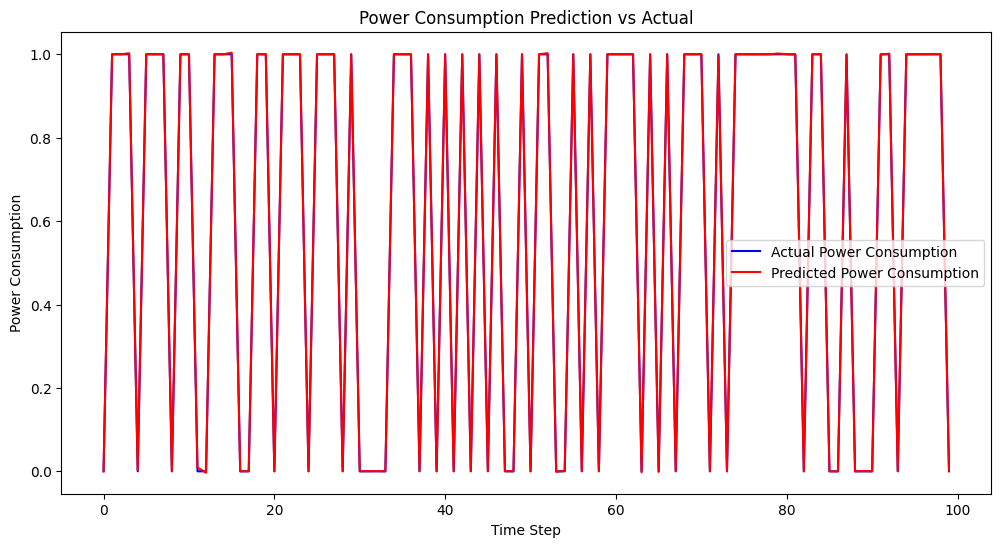

In [49]:
import matplotlib.pyplot as plt

# Plot actual vs predicted power consumption (for the test set)
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', color='blue')
plt.plot(best_models["LightGBM"].predict(X_test[:100]), label='Predicted Power Consumption', color='red')
plt.legend()
plt.title('Power Consumption Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Power Consumption')
plt.show()
